
# Vibe Matcher – Runner

**Goal:** Input a *vibe* (natural language) → embed query + products → cosine similarity → return top‑3 items with scores.

**Why AI at Nexora (1‑para intro):**  
Nexora ships AI that feels practical and end‑to‑end. This prototype shows that mindset in miniature: clean data scaffolding, OpenAI embeddings for semantic matching, a simple but explainable vector search, lightweight evaluation with latency logging, and clear upgrade paths (FAISS/Pinecone, query rewriting, re‑ranking). It’s intentionally small but production‑minded—easy to read, easy to extend, and measurable. I am an avid learner, and really want to explore ai and ml, after bunch of theory courses. 


In [1]:


import os, sys, time
from pathlib import Path
import numpy as np
import pandas as pd
from dotenv import load_dotenv



load_dotenv()  # make OPENAI_API_KEY available
DATA_CSV = Path("data/mock_fashion.csv")
CACHE_PKL = Path("data/fashion_with_embeddings.pkl")


In [2]:


assert DATA_CSV.exists(), f"Missing {DATA_CSV}. Create it from your DataFrame via df.to_csv('data/mock_fashion.csv', index=False)."
df_raw = pd.read_csv(DATA_CSV)
df_raw.head(3)


,name,desc,vibes
0,Boho Maxi Dress,Flowy cotton maxi with earthy tones and tassel...,"['boho', 'earthy', 'relaxed']"
1,Streetwear Hoodie,Oversized black hoodie with graffiti prints fo...,"['urban', 'energetic', 'street']"
2,Minimalist Blazer,Sleek beige blazer with clean lines and neutra...,"['minimal', 'formal', 'modern']"


In [ ]:


from src.embed import embed_csv
#put use_local=TRUE to use local sentence transformer 
df = embed_csv(csv_path=str(DATA_CSV), model="text-embedding-3-small", save_path=str(CACHE_PKL),use_local=False)
len(df), df.head(2)

Embedding descriptions: 100%|██████████| 8/8 [00:00<00:00, 83.44it/s]


(8,
                 name                                               desc  \
 0    Boho Maxi Dress  Flowy cotton maxi with earthy tones and tassel...   
 1  Streetwear Hoodie  Oversized black hoodie with graffiti prints fo...   
 
                               vibes  \
 0     ['boho', 'earthy', 'relaxed']   
 1  ['urban', 'energetic', 'street']   
 
                                            embedding  
 0  [-0.1083788201212883, 0.03439360484480858, 0.0...  
 1  [-0.06419062614440918, 0.16721375286579132, -0...  )

In [7]:

from src.search import build_index, rank_by_cosine, fallback_if_weak
from src.embed import embed_texts  # reuse for single query: embed_texts([q])[0]

# Build index once
matrix, meta = build_index(df, embed_col="embedding")

# Try a vibe query
query = "energetic urban chic"
q_vec = np.array(embed_texts([query], model="text-embedding-3-small")[0], dtype=np.float32)

top3 = rank_by_cosine(q_vec, matrix, meta, top_k=3)
top3 = fallback_if_weak(top3, min_sim=0.70)
top3


Embedding descriptions: 100%|██████████| 1/1 [00:00<00:00, 116.45it/s]


,name,desc,vibes,score,weak_match
0,Streetwear Hoodie,Oversized black hoodie with graffiti prints fo...,"['urban', 'energetic', 'street']",0.290937,True
1,Boho Maxi Dress,Flowy cotton maxi with earthy tones and tassel...,"['boho', 'earthy', 'relaxed']",0.225259,True
2,Vintage Denim Jacket,"Faded blue denim jacket with metal buttons, ev...","['vintage', 'cool', 'retro']",0.194144,True


In [9]:

test_queries = [
    "energetic urban chic",
    "vintage cool retro",
    "traditional festive elegance",
]

rows = []
for q in test_queries:
    qv = np.array(embed_texts([q], model="text-embedding-3-small")[0], dtype=np.float32)
    res = rank_by_cosine(qv, matrix, meta, top_k=3)
    res = fallback_if_weak(res, min_sim=0.70)
    best = float(res["score"].iloc[0])
    rows.append({"query": q, "best_score": best, "good_match": best >= 0.70, "top1": res['name'].iloc[0]})

eval_df = pd.DataFrame(rows)
hit_rate = eval_df["good_match"].mean()
eval_df, hit_rate


Embedding descriptions: 100%|██████████| 1/1 [00:00<00:00, 111.59it/s]


(                          query  best_score  good_match                  top1
 0          energetic urban chic    0.290937       False     Streetwear Hoodie
 1            vintage cool retro    0.532859       False  Vintage Denim Jacket
 2  traditional festive elegance    0.460631       False       Boho Maxi Dress,
 np.float64(0.0))

Embedding descriptions: 100%|██████████| 1/1 [00:00<00:00, 74.97it/s]


,query,embed_ms,search_ms,total_ms
0,energetic urban chic,11.7009,1.5026,13.2035
1,vintage cool retro,13.5088,2.0188,15.5276
2,traditional festive elegance,15.3245,1.7542,17.0787


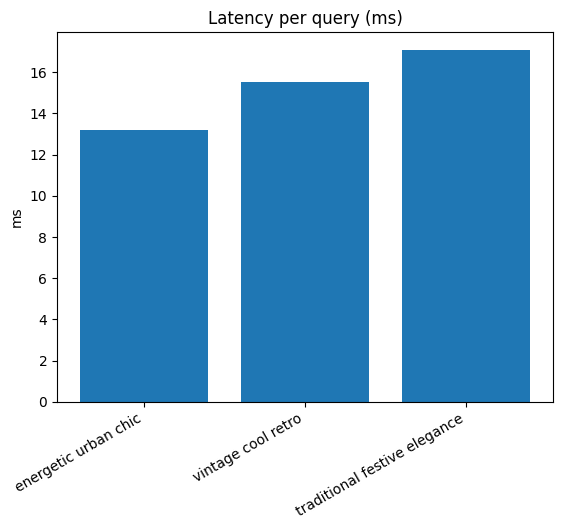

In [10]:

import matplotlib.pyplot as plt

def time_one(q: str):
    t0 = time.perf_counter()
    qv = embed_texts([q], model="text-embedding-3-small")[0]
    t1 = time.perf_counter()
    _ = rank_by_cosine(np.array(qv, dtype=np.float32), matrix, meta, top_k=3)
    t2 = time.perf_counter()
    return {"query": q, "embed_ms": (t1 - t0)*1000, "search_ms": (t2 - t1)*1000, "total_ms": (t2 - t0)*1000}

lat_rows = [time_one(q) for q in test_queries]
lat_df = pd.DataFrame(lat_rows)
display(lat_df)

plt.figure()
plt.bar(lat_df["query"], lat_df["total_ms"])
plt.title("Latency per query (ms)")
plt.ylabel("ms")
plt.xticks(rotation=30, ha="right")
plt.show()


In [11]:

odd_query = "glam punk couture with neon feathers"
qv = np.array(embed_texts([odd_query], model="text-embedding-3-small")[0], dtype=np.float32)
res = rank_by_cosine(qv, matrix, meta, top_k=3)
res = fallback_if_weak(res, min_sim=0.30)
res


Embedding descriptions: 100%|██████████| 1/1 [00:00<00:00, 53.56it/s]


,name,desc,vibes,score,weak_match
0,Artsy Graphic Tee,"White cotton tee with abstract art prints, pla...","['artsy', 'fun', 'creative']",0.379951,False
1,Vintage Denim Jacket,"Faded blue denim jacket with metal buttons, ev...","['vintage', 'cool', 'retro']",0.374362,False
2,Boho Maxi Dress,Flowy cotton maxi with earthy tones and tassel...,"['boho', 'earthy', 'relaxed']",0.348085,False



## Reflection (Improvements & Edge Cases)
- **Indexing at scale**: swap cosine loop for FAISS or Pinecone (IVF/Flat) for millions of items; store vectors + metadata.
- **Query rewriting**: expand short or niche vibes (e.g., “chic urban”) into richer descriptors before embedding.
- **Re‑ranking**: combine cosine score with tag overlap (`vibes`) or brand/category filters for hybrid ranking.
- **Caching**: memoize embeddings per text to avoid re‑hitting the API during iterations.
- **Fallback UX**: if `max(score) < 0.30`, present closest matches + suggest broader terms to the user.
